# 요약할 텍스트 로드

In [1]:
import urllib.request
import pandas as pd
import numpy as np
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
34165,Apple's Watch Series 3 with LTE to launch in I...,After launching the Apple Watch Series 3 late ...
63686,India breaks attendance record for the FIFA U-...,Debutant FIFA hosts India broke the record for...
58153,US pulls out of UN's migrant and refugee pact,The United States on Saturday announced its wi...
94418,No liquor shop in 94% of Chhattisgarh villages...,Chhattisgarh Chief Minister Raman Singh has cl...
89061,Flipkart's Big 10 Sale begins today,Flipkart's Big 10 Sale starts with a bang toda...
60263,Bengaluru man attacks traffic cop who stopped ...,A video showing a businessman abusing and assa...
39142,Ranveer shares first still from Rohit Shetty's...,Ranveer Singh took to Instagram to share the f...
38508,Work can't be bartered for favours: Aditi on c...,"Actress Aditi Rao Hydari, while speaking about..."
15437,Melting Arctic ice opens new Europe-east Asia ...,An AP Moller-Maersk cargo ship has successfull...
68802,Facebook tests WhatsApp button in its app on A...,Social media major Facebook is testing a dedic...


# 추출적 요약 Extractive Summaization

In [2]:
from summa.summarizer import summarize

print("headlines : ",data.iloc[0, 0])
print("extractive summarization : ", summarize(data.iloc[0, 1], ratio=0.4))

headlines :  upGrad learner switches to career in ML & Al with 90% salary hike
extractive summarization :  upGrad's Online Power Learning has powered 3 lakh+ careers.


In [3]:
res_ext = data["text"].apply(lambda x : summarize(x, ratio=0.4))
res_ext = res_ext.rename("extractive_summary")
res_ext

0        upGrad's Online Power Learning has powered 3 l...
1        Users get one CRED coin per rupee of bill paid...
2        The match witnessed India getting all out for ...
3        Also, customers have options to insure against...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    Michael B Jordan will reportedly play the lead...
98399    The video also shows a TV airing a news confer...
98400                                                     
Name: extractive_summary, Length: 98401, dtype: object

In [4]:
summary_df = data.copy()
summary_df = summary_df.drop(columns=["text"])
summary_df = pd.concat([summary_df, res_ext], axis=1)
summary_df

,headlines,extractive_summary
0,upGrad learner switches to career in ML & Al w...,upGrad's Online Power Learning has powered 3 l...
1,Delhi techie wins free food from Swiggy for on...,Users get one CRED coin per rupee of bill paid...
2,New Zealand end Rohit Sharma-led India's 12-ma...,The match witnessed India getting all out for ...
3,Aegon life iTerm insurance plan helps customer...,"Also, customers have options to insure against..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
...,...,...
98396,CRPF jawan axed to death by Maoists in Chhatti...,A CRPF jawan was on Tuesday axed to death with...
98397,First song from Sonakshi Sinha's 'Noor' titled...,"'Uff Yeh', the first song from the Sonakshi Si..."
98398,'The Matrix' film to get a reboot: Reports,Michael B Jordan will reportedly play the lead...
98399,Snoop Dogg aims gun at clown dressed as Trump ...,The video also shows a TV airing a news confer...


# 추상적 요약 Abstractive Summarization
## 1. 전처리
### 1.1 전처리 준비

In [5]:
# 데이터 개수 파악
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98401 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98401 non-null  object
 1   text       98401 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [6]:
# 데이터 중복이 아닌 데이터 개수 확인
print("헤드라인의 중복이 아닌 개수 : ", data["headlines"].nunique())
print("중복이 아닌 텍스트 개수 : ", data["text"].nunique())

헤드라인의 중복이 아닌 개수 :  98280
중복이 아닌 텍스트 개수 :  98360


In [7]:
# 텍스트는 98401개이나 중복이 아닌 텍스트가 98,360으로 중복 데이터가 41개 존재
# 위 결과 중복된 텍스트가 존재하므로 중복을 제거하자

data.drop_duplicates(subset=["text"], inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98360 entries, 0 to 98400
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headlines  98360 non-null  object
 1   text       98360 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB
None


In [8]:
"""
중복 텍스트를 제거한 결과 헤드라인과 텍스트가 98,360개가 되었다.
이번에는 널 데이터를 확인하고 제거하자
"""
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [9]:
# 널처리를 하려고했으나 널데이터가 존재하지 않는다
# 다음으로 텍스트 정규화 사전을 준비하자.
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

len(contractions)

import re
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [10]:
# 정규화 사전을 준비하였으니 이번에는 불용어를 확인해보자
from nltk.corpus import stopwords
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### 1.2 데이터 전처리

In [11]:
# 정규표현식과 정규화 사전을 이용하여 전처리를 하고, 토큰화를 시키자
import re

def preprocessing(sentence, remove_stopwords=True):
    sentence = sentence.lower()
    sentence = re.sub(r"\([^)]*\)","",sentence)
    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])
    sentence = re.sub(r"'s\b","", sentence)
    sentence = re.sub("[^a-zA-Z]", " ", sentence)
    sentence = re.sub("[m]{2,}","mm", sentence)
    
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headline = 'Great way to start (or finish) the day!!!'

print(preprocessing(temp_text))
print(preprocessing(temp_headline, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered br mother father
great way to start the day


In [13]:
preprocessed_text = []
preprocessed_headlines = []

for headline in data["headlines"]:
    preprocessed_headlines.append(preprocessing(headline, False))

for text in data["text"]:
    preprocessed_text.append(preprocessing(text))

In [14]:
data["text"] = preprocessed_text
data["headlines"] = preprocessed_headlines

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 1.3 인코더, 디코더 데이터 준비

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


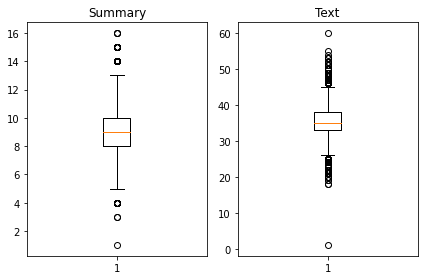

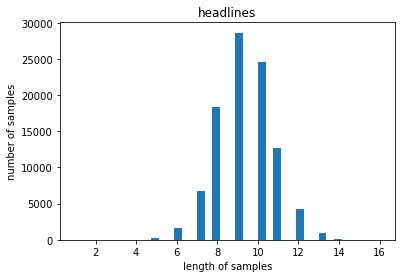

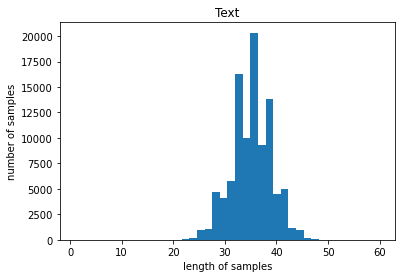

In [16]:
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
text_max_len = 45
headlines_max_len = 13

In [18]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [19]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [20]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 97863


In [21]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [22]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### 1.4 훈련/테스트 데이터 분할

In [23]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[56068  4005 24100 ... 31279 56072 60642]


In [24]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [25]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 19572


In [26]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


### 1.5 단어들을 정수로 인코딩 하기

In [27]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [28]:
threshold = 7
total_cnt = len(src_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69300
등장 빈도가 6번 이하인 희귀 단어의 수: 47164
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22136
단어 집합에서 희귀 단어의 비율: 68.05772005772006
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.483574012743308


In [29]:
"""
등장 빈도가 6이하인 단어는 47,276으로 전체 단어들 중 70%가까이 차지함.
하지만 이 희귀단어의 등장 빈도는 전체에서 3.5% 정도.
이 희귀단어들을 전체 단어집합에서 제외한 경우 크기 22,066
-> 사용할 단어 집합의 크기를 22,000으로 하자

"""
src_vocab = 22000
src_tokenizer = Tokenizer(num_words = src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train)

In [30]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[36, 16, 180, 130, 59, 1, 58, 22, 608, 206, 2197, 1648, 51, 2151, 474, 1837, 2151, 51, 600, 21, 10030, 792, 252, 1305, 2, 9842, 36, 4, 58, 22, 7765, 62, 16, 3681], [136, 230, 626, 4847, 6860, 451, 128, 197, 561, 381, 311, 1522, 518, 455, 21, 2548, 1338, 227, 1522, 480, 1782, 4026, 322, 2421, 3682, 1, 15311, 12876, 127, 518, 1458, 705, 4592, 888, 890, 186, 2849, 825], [3, 13, 37, 215, 3709, 86, 275, 17403, 226, 382, 401, 41, 1037, 3318, 4392, 604, 77, 6622, 888, 2232, 54, 1037, 77, 415, 955, 3318, 4392, 437, 466, 334, 29, 3]]


In [31]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [32]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) 
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29974
등장 빈도가 5번 이하인 희귀 단어의 수: 19569
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10405
단어 집합에서 희귀 단어의 비율: 65.28658170414359
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.644771435735619


In [33]:
"""
디코더 훈련 데이터에서
길이가 5이하인 희귀 단어의 수는 19,576개
이들을 제외한 단어 집합의 크기 10,398
단어 집합에서 차지하는 희귀단어의 비율 65.3%
전체에서 희귀단어 등장 빈도 4.6%
-> 디코더의 단어 크기를 10,000개로 하자

"""

tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24, 118, 240, 1793, 67, 2307, 341, 75, 201], [1, 2723, 1429, 8165, 5, 137, 253, 208, 5186], [1, 1870, 83, 4, 1975, 2447, 340, 66], [1, 2668, 59, 1327, 20, 9, 3023], [1, 603, 2724, 83, 112, 1064, 2725, 4, 4378]]
target
decoder  [[24, 118, 240, 1793, 67, 2307, 341, 75, 201, 2], [2723, 1429, 8165, 5, 137, 253, 208, 5186, 2], [1870, 83, 4, 1975, 2447, 340, 66, 2], [2668, 59, 1327, 20, 9, 3023, 2], [603, 2724, 83, 112, 1064, 2725, 4, 4378, 2]]


In [34]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print("삭제할 훈련 데이터 개수 : ",len(drop_train))
print("삭제할 테스트 데이터 개수 : ", len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터 개수 :  0
삭제할 테스트 데이터 개수 :  0
훈련 데이터의 개수 : 78291
훈련 레이블의 개수 : 78291
테스트 데이터의 개수 : 19572
테스트 레이블의 개수 : 19572


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

## 2. 모델 설계하기
### 2.1 인코더 모델 설계하기

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


embedding_dim = 128
hidden_size = 256

encoder_inputs = Input(shape=(text_max_len,))
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 2.2 디코더 모델 설계하기

In [37]:
decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [38]:
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 2.3 어텐션 모델로 만들기

In [39]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [40]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2816000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 3. 모델 학습하기

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
306/306 [==============================] - 114s 374ms/step - loss: 5.2316 - val_loss: 4.8250
Epoch 2/50
306/306 [==============================] - 114s 372ms/step - loss: 4.6784 - val_loss: 4.4451
Epoch 3/50
306/306 [==============================] - 115s 377ms/step - loss: 4.3503 - val_loss: 4.1996
Epoch 4/50
306/306 [==============================] - 115s 377ms/step - loss: 4.1000 - val_loss: 4.0147
Epoch 5/50
306/306 [==============================] - 121s 395ms/step - loss: 3.9070 - val_loss: 3.8775
Epoch 6/50
306/306 [==============================] - 127s 414ms/step - loss: 3.7485 - val_loss: 3.7721
Epoch 7/50
306/306 [==============================] - 115s 377ms/step - loss: 3.6109 - val_loss: 3.6867
Epoch 8/50
306/306 [==============================] - 116s 378ms/step - loss: 3.4938 - val_loss: 3.6162
Epoch 9/50
306/306 [==============================] - 117s 383ms/step - loss: 3.3876 - val_loss: 3.5598
Epoch 10/50
306/306 [==============================] - 116s 381m

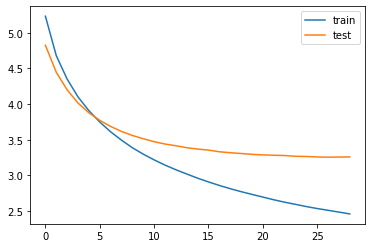

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 4. 추론 모델 설계하기

In [43]:
# 인덱스로 단어, 단어로 인덱스 딕셔너리 구하기
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

In [44]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [45]:
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [49]:
# 입력 시퀀스로부터 요약한 시퀀스를 반환하는 함수
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

## 5. 추론 모델 테스트

In [47]:
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : centre saturday dismissed reports suggested agreed larger nagaland state reports erroneous clarified agreement decision government home ministry spokesperson said comes im said centre accepted territorial integration naga inhabited areas 
실제 요약 : govt dismisses reports of out larger nagaland state 
예측 요약 :  govt denies reports of government bailout plan


원문 : least people killed others injured friday car bomb exploded afghanistan province officials said bomb exploded outside sports stadium city comes days people killed others wounded isis attack capital kabul 
실제 요약 : killed injured in car bomb explosion in afghanistan 
예측 요약 :  killed injured in car bomb blast in afghanistan


원문 : slamming opposition bjp leader union minister giriraj singh sunday tweeted maoists casteist supporters attacks mastermind osama bin laden united nda added opposition efforts towards united front impact since nda successfully win elections development agenda 
실제 요약 : bjp minister calls opposition leade

예측 요약 :  paytm acquires stake in startup


원문 : international atomic energy agency confirmed iran fully implementing obligations nuclear deal adding middle east nation subject world robust nuclear verification comes us president donald trump announced decision decertify deal threatened pull 
실제 요약 : iran facing world most verification nuke watchdog 
예측 요약 :  iran to nuclear deal with nuclear deal in us


원문 : jsw steel joint md rao said indian steel industry jio moment despite entry world largest steelmaker arcelormittal lakshmi mittal led company recently emerged winning bidder acquire essar steel jsw said entry arcelormittal would good competition india steel market room growth 
실제 요약 : arcelormittal cannot do jio in indian steel industry steel 
예측 요약 :  tata steel steel nifty surges to acquire tata steel


원문 : senior spokesperson karni sena unit chittorgarh claimed women signed jauhar comes supreme court rejected pleas rajasthan madhya pradesh seeking modification order lifted ban 

예측 요약 :  ed attaches assets worth crore in nirav modi


원문 : former indian pacer chetan sharma bowled three new zealand batsmen three successive deliveries october nagpur becoming first bowler take hat trick cricket world cup match also first hat trick taken indian first bowled hat trick international cricket 
실제 요약 : first ever hat trick in world cup was taken by an indian 
예측 요약 :  indian pacer once took hat trick in odi cricket


원문 : supplier booked providing fake jewellery mass marriage programme organised uttar pradesh government eight women returned ornaments saying made silver district social welfare department role also assessed official said wedding took place vivah yojana wherein state spends bride 
실제 요약 : up brides get fake jewellery in state organised mass wedding 
예측 요약 :  fake jewellery jewellery in assam couple held for marry


원문 : mother ag one convicts rajiv gandhi assassination case met tamil nadu governor banwarilal purohit seeking son release following cabinet re